Loading data...
Data Information:
Data shape: (901767, 36)
Number of feature columns used: 33
Data shape after removing missing values: (901767, 36)
Using all 901767 rows for analysis

Step 1: Computing correlations for all original features...
Computing correlation coefficients...
Original feature correlation computation completed in 1.80 seconds

Step 2: Generating interaction features from ALL 33 original features...
Generating all pairwise interactions...
Total interactions to generate: 528


Generating interactions: 100%|██████████| 528/528 [00:01<00:00, 418.32it/s]


Generated 528 interaction features in 1.31 seconds
Total features: 561 (Original: 33, Interactions: 528)

Step 3: Data preprocessing...


Winsorizing features: 100%|██████████| 561/561 [00:08<00:00, 63.79it/s]


Standardizing features...
Data preprocessing completed in 31.75 seconds

Step 4: Computing correlation coefficients for all features...
Computing correlation coefficients...
Correlation computation completed in 463.88 seconds

Step 5: Computing mutual information...
Computing mutual information in batches of 30 features...


Computing MI: 100%|██████████| 19/19 [51:04<00:00, 161.29s/it]


Mutual information computation completed in 3064.42 seconds

Step 6: Organizing analysis results...
Applying nonlinearity tests...


Nonlinearity testing: 100%|██████████| 561/561 [00:00<00:00, 19823.29it/s]



ANALYSIS RESULTS SUMMARY
Total number of features: 561
Features with nonlinear relationships: 394 (70.2%)

Original Features:
  - Total: 33
  - Nonlinear: 20 (60.6%)
  - Average MI: 0.0217

Interaction Features:
  - Total: 528
  - Nonlinear: 374 (70.8%)
  - Average MI: 0.0133

TOP 15 MOST IMPORTANT FEATURES (by Mutual Information)
 1. 🔵 Turnover_Liquidility                     MI: 0.0740 Corr: -0.0806 Type: Interaction
 2. 🔵 Turnover                                 MI: 0.0722 Corr: +0.1103 Type: Original
 3. 🔴 NAV_RevenueGrowth                        MI: 0.0457 Corr: -0.0045 Type: Interaction
 4. 🔴 RevenuePerShare_RevenueGrowth            MI: 0.0447 Corr: -0.0010 Type: Interaction
 5. 🔴 EPS                                      MI: 0.0440 Corr: -0.0020 Type: Original
 6. 🔴 OGS                                      MI: 0.0430 Corr: +0.0005 Type: Original
 7. 🔴 EquityGrowth                             MI: 0.0427 Corr: +0.0017 Type: Original
 8. 🔴 OperatingNCFPerShare_RevenueGrowth       M

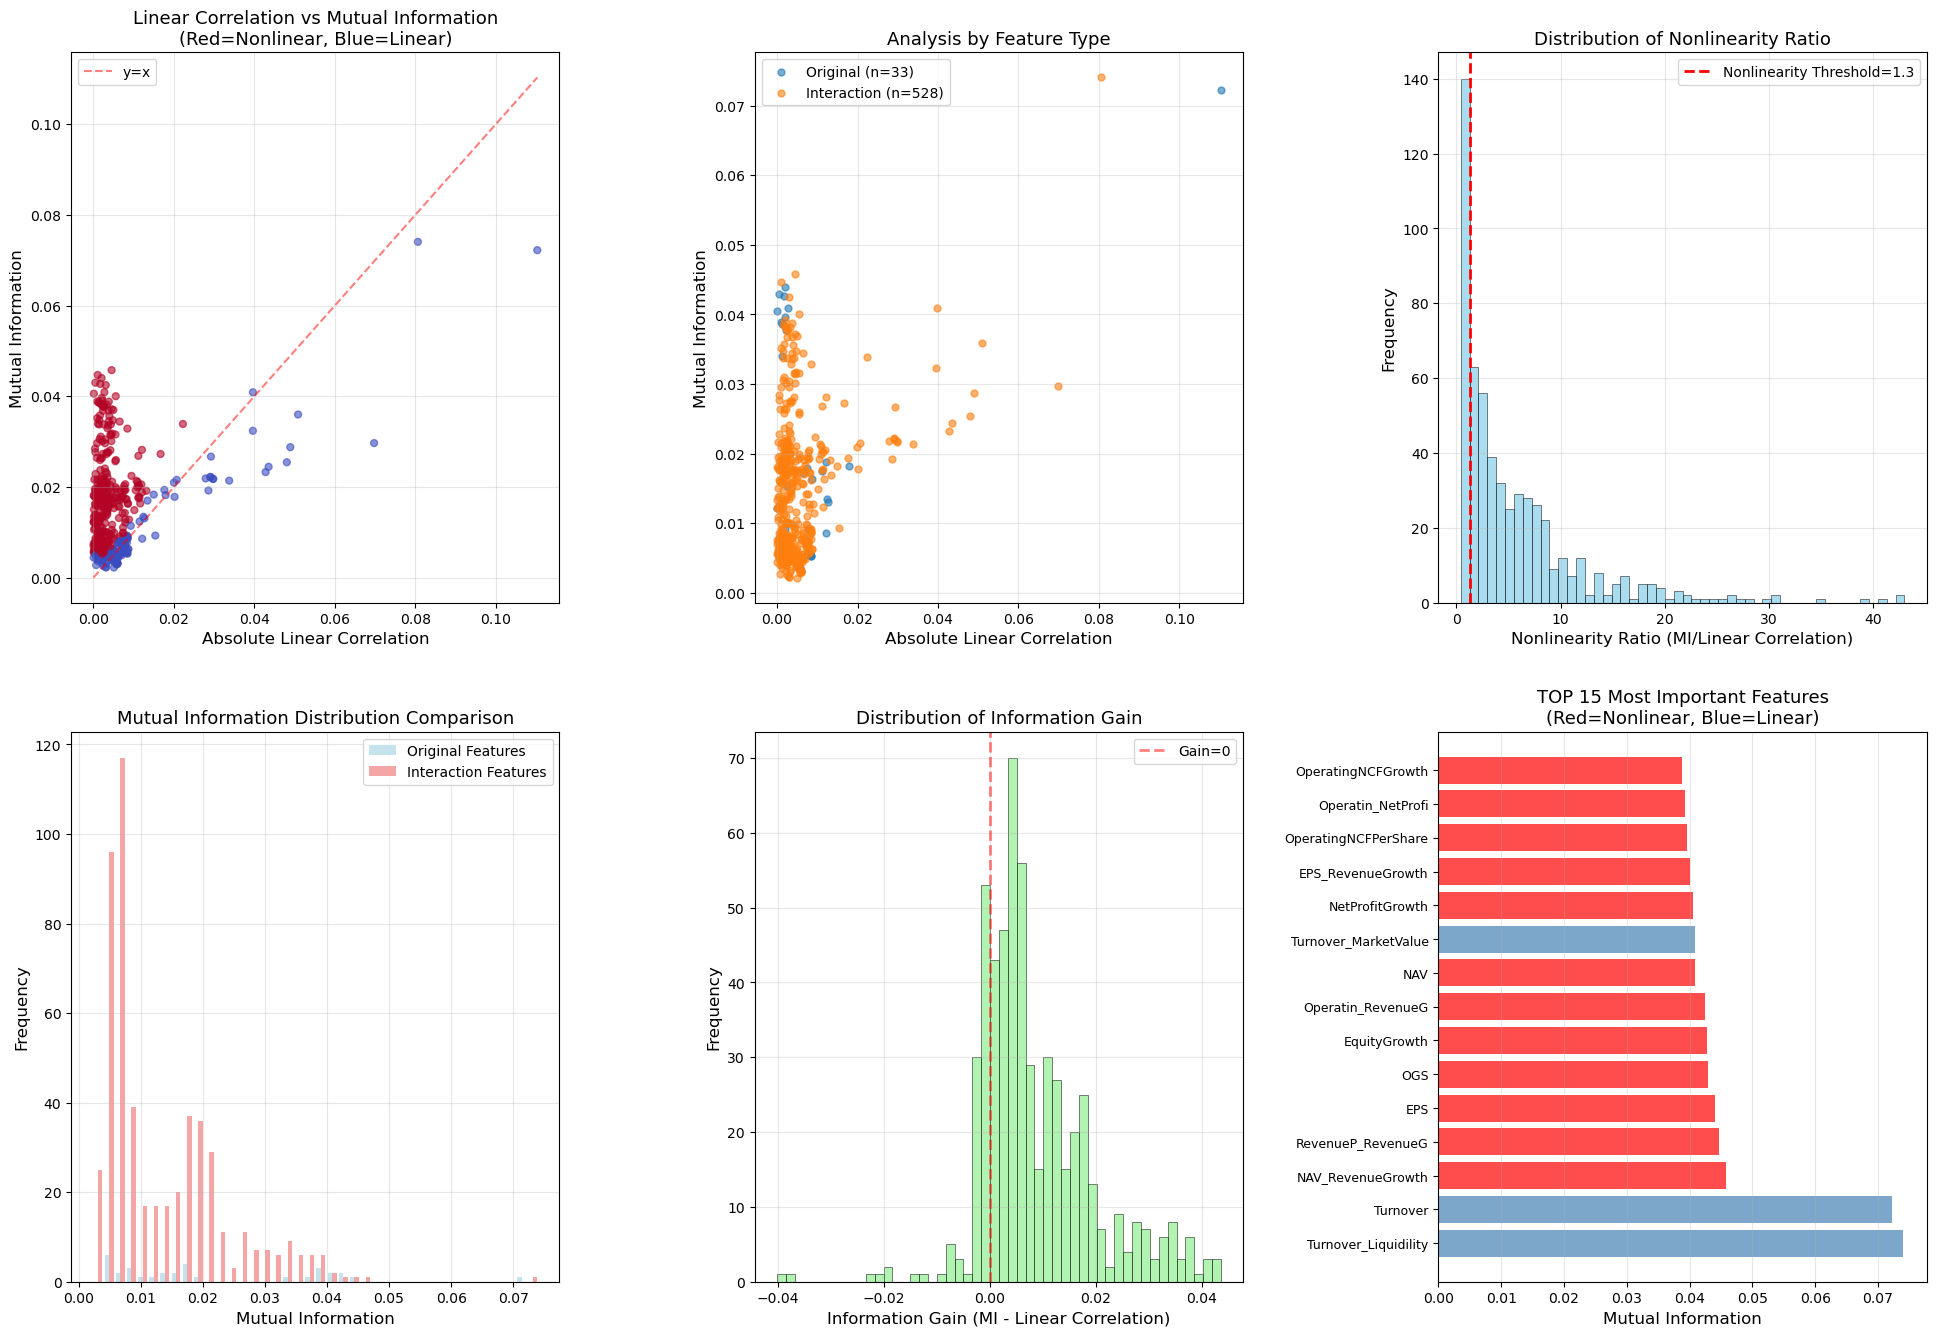


✅ Analysis results saved to: /Users/xiaoquanliu/Desktop/complete_feature_analysis_results.csv

ADDITIONAL STATISTICS
Data processing summary:
  - Original dataset size: (901767, 36)
  - After cleaning: (901767, 36)
  - Original features: 33
  - Interaction features: 528
  - Total features analyzed: 561
  - Nonlinear features found: 394
  - Nonlinearity rate: 70.23%

Feature classification by MI strength:
  - High MI (>0.01): 264 features
  - Medium MI (0.005-0.01): 230 features
  - Low MI (≤0.005): 67 features

✅ Complete analysis finished successfully!


In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from sklearn.preprocessing import StandardScaler
import time
from tqdm import tqdm  # 用于显示进度条
warnings.filterwarnings('ignore')

# 设置英文字体和更大的图形尺寸
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.dpi'] = 100

def efficient_mutual_info(X, y, batch_size=50):
    """高效的互信息计算，分批处理避免内存问题"""
    n_features = X.shape[1]
    mutual_info_scores = np.zeros(n_features)
    
    print(f"Computing mutual information in batches of {batch_size} features...")
    
    for i in tqdm(range(0, n_features, batch_size), desc="Computing MI"):
        end_idx = min(i + batch_size, n_features)
        X_batch = X.iloc[:, i:end_idx]
        
        # 计算当前批次的互信息
        mi_batch = mutual_info_regression(X_batch, y, random_state=42, n_neighbors=5)
        mutual_info_scores[i:end_idx] = mi_batch
        
    return mutual_info_scores

def fast_correlation_calculation(X, y):
    """快速计算所有特征与目标变量的相关系数"""
    print("Computing correlation coefficients...")
    
    # 将y转换为与X相同的DataFrame格式
    X_with_y = pd.concat([X, pd.Series(y, name='target', index=X.index)], axis=1)
    
    # 计算相关系数矩阵
    corr_matrix = X_with_y.corr()
    
    # 提取与目标变量的相关系数
    pearson_corrs = corr_matrix['target'].iloc[:-1].values  # 排除target与自己的相关性
    
    return pearson_corrs

# 1. 导入数据
print("Loading data...")
file_path = '/Users/xiaoquanliu/Desktop/Book_DataCode1/第七章/DL_Data16_processed.csv'
df = pd.read_csv(file_path)

print("Data Information:")
print(f"Data shape: {df.shape}")

# 提取33个特征列
feature_columns = ['Beta1', 'Beta2', 'Cor1', 'Cor2', 'NonSysRisk1', 'NonSysRisk2', 
                   'Rsq1', 'Rsq2', 'ARsq1', 'ARsq2', 'PE', 'PB', 'PCF', 'PS', 
                   'DividentPerShare', 'Turnover', 'Liquidility', 'MarketValue', 
                   'EPS', 'EPSToP', 'NAV', 'NAVToP', 'RevenuePerShare', 
                   'RevenuePerShareToP', 'OperatingNCFPerShare', 'OperatingNCFPerShareToP', 
                   'OVS', 'NetProfitGrowth', 'EquityGrowth', 'RevenueGrowth', 
                   'OperatingNCFGrowth', 'OGS', 'VCG']

# 检查特征列是否存在
missing_cols = [col for col in feature_columns if col not in df.columns]
if missing_cols:
    print(f"Warning: The following columns are missing: {missing_cols}")
    feature_columns = [col for col in feature_columns if col in df.columns]

print(f"Number of feature columns used: {len(feature_columns)}")

# 处理缺失值
df_clean = df.dropna()
print(f"Data shape after removing missing values: {df_clean.shape}")

# **优化1：使用全部数据，不进行采样**
print(f"Using all {len(df_clean)} rows for analysis")
df_sample = df_clean.copy()

# 提取原始特征和目标变量
X_original = df_sample[feature_columns].copy()
y = df_sample['Return'].copy()

# **优化2：使用所有原始特征生成交互特征**
print("\nStep 1: Computing correlations for all original features...")
start_time = time.time()

# 快速计算原始特征的相关性
original_corrs = fast_correlation_calculation(X_original, y)

print(f"Original feature correlation computation completed in {time.time() - start_time:.2f} seconds")

# **重要修改：使用所有原始特征生成交互特征**
print(f"\nStep 2: Generating interaction features from ALL {len(feature_columns)} original features...")
start_time = time.time()

interaction_features = pd.DataFrame(index=df_sample.index)
interaction_names = []

# 生成所有原始特征之间的两两交互
print("Generating all pairwise interactions...")
total_interactions = len(feature_columns) * (len(feature_columns) - 1) // 2
print(f"Total interactions to generate: {total_interactions}")

with tqdm(total=total_interactions, desc="Generating interactions") as pbar:
    for i, col1 in enumerate(feature_columns):
        for j, col2 in enumerate(feature_columns[i+1:], i+1):
            interaction_name = f"{col1}_{col2}"
            interaction_features[interaction_name] = X_original[col1] * X_original[col2]
            interaction_names.append(interaction_name)
            pbar.update(1)

print(f"Generated {len(interaction_names)} interaction features in {time.time() - start_time:.2f} seconds")

# 合并所有特征
X = pd.concat([X_original, interaction_features], axis=1)
print(f"Total features: {X.shape[1]} (Original: {len(feature_columns)}, Interactions: {len(interaction_names)})")

# **优化3：数据预处理**
print("\nStep 3: Data preprocessing...")
start_time = time.time()

# 处理异常值（使用分位数截断）
def winsorize_features(df, lower=0.01, upper=0.99):
    """对特征进行缩尾处理"""
    df_win = df.copy()
    for col in tqdm(df.columns, desc="Winsorizing features"):
        lower_bound = df[col].quantile(lower)
        upper_bound = df[col].quantile(upper)
        df_win[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df_win

X_winsorized = winsorize_features(X)

# 标准化
print("Standardizing features...")
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_winsorized), 
    columns=X.columns, 
    index=X.index
)

print(f"Data preprocessing completed in {time.time() - start_time:.2f} seconds")

# **优化4：快速相关性计算**
print("\nStep 4: Computing correlation coefficients for all features...")
start_time = time.time()

pearson_corrs = fast_correlation_calculation(X_scaled, y)

print(f"Correlation computation completed in {time.time() - start_time:.2f} seconds")

# **优化5：高效互信息计算**
print("\nStep 5: Computing mutual information...")
start_time = time.time()

# 使用优化的互信息计算，调整批次大小以适应更多特征
batch_size = min(30, X_scaled.shape[1] // 10)  # 动态调整批次大小
mutual_info_scores = efficient_mutual_info(X_scaled, y, batch_size=batch_size)

print(f"Mutual information computation completed in {time.time() - start_time:.2f} seconds")

# 创建结果DataFrame
print("\nStep 6: Organizing analysis results...")
results_df = pd.DataFrame({
    'Feature': X.columns,
    'Pearson_Corr': pearson_corrs,
    'Mutual_Info': mutual_info_scores,
    'Abs_Pearson': np.abs(pearson_corrs),
    'Feature_Type': (['Original'] * len(feature_columns) + 
                    ['Interaction'] * len(interaction_names))
})

# 非线性关系检验
def advanced_nonlinearity_test(pearson_corr, mutual_info):
    """改进的非线性检验方法"""
    abs_pearson = np.abs(pearson_corr)
    
    # 方法1：比率检验
    if abs_pearson > 0.001:
        ratio = mutual_info / abs_pearson
    else:
        ratio = mutual_info * 1000
    
    # 方法2：差值检验
    info_gain = mutual_info - abs_pearson
    
    # 方法3：综合判断
    # 非线性的条件：
    # 1. 互信息明显大于线性相关
    # 2. 互信息本身有一定强度
    # 3. 比率超过阈值
    
    is_nonlinear = (
        (ratio > 1.3) and 
        (mutual_info > 0.005) and 
        (info_gain > 0.002)
    )
    
    return ratio, info_gain, is_nonlinear

# 应用非线性检验
print("Applying nonlinearity tests...")
results_df['Nonlinearity_Ratio'] = 0.0
results_df['Info_Gain'] = 0.0
results_df['Is_Nonlinear'] = False

for i in tqdm(range(len(results_df)), desc="Nonlinearity testing"):
    row = results_df.iloc[i]
    ratio, gain, is_nonlinear = advanced_nonlinearity_test(
        row['Pearson_Corr'], row['Mutual_Info']
    )
    results_df.at[i, 'Nonlinearity_Ratio'] = ratio
    results_df.at[i, 'Info_Gain'] = gain
    results_df.at[i, 'Is_Nonlinear'] = is_nonlinear

# 结果分析
print("\n" + "="*60)
print("ANALYSIS RESULTS SUMMARY")
print("="*60)

total_features = len(results_df)
nonlinear_count = results_df['Is_Nonlinear'].sum()
nonlinear_pct = nonlinear_count / total_features * 100

print(f"Total number of features: {total_features}")
print(f"Features with nonlinear relationships: {nonlinear_count} ({nonlinear_pct:.1f}%)")

# 按特征类型分析
original_results = results_df[results_df['Feature_Type'] == 'Original']
interaction_results = results_df[results_df['Feature_Type'] == 'Interaction']

orig_nonlinear = original_results['Is_Nonlinear'].sum()
inter_nonlinear = interaction_results['Is_Nonlinear'].sum()

print(f"\nOriginal Features:")
print(f"  - Total: {len(original_results)}")
print(f"  - Nonlinear: {orig_nonlinear} ({orig_nonlinear/len(original_results)*100:.1f}%)")
print(f"  - Average MI: {original_results['Mutual_Info'].mean():.4f}")

print(f"\nInteraction Features:")
print(f"  - Total: {len(interaction_results)}")
print(f"  - Nonlinear: {inter_nonlinear} ({inter_nonlinear/len(interaction_results)*100:.1f}%)")
print(f"  - Average MI: {interaction_results['Mutual_Info'].mean():.4f}")

# 显示最重要的特征
print(f"\n" + "="*60)
print("TOP 15 MOST IMPORTANT FEATURES (by Mutual Information)")
print("="*60)

top_features_result = results_df.nlargest(15, 'Mutual_Info')
for i, (_, row) in enumerate(top_features_result.iterrows(), 1):
    nonlinear_flag = "🔴" if row['Is_Nonlinear'] else "🔵"
    print(f"{i:2d}. {nonlinear_flag} {row['Feature']:<40} "
          f"MI: {row['Mutual_Info']:.4f} "
          f"Corr: {row['Pearson_Corr']:+.4f} "
          f"Type: {row['Feature_Type']}")

# 显示非线性特征
nonlinear_features = results_df[results_df['Is_Nonlinear']].nlargest(10, 'Mutual_Info')
if len(nonlinear_features) > 0:
    print(f"\n" + "="*60)
    print("TOP 10 NONLINEAR RELATIONSHIP FEATURES")
    print("="*60)
    
    for i, (_, row) in enumerate(nonlinear_features.iterrows(), 1):
        print(f"{i:2d}. {row['Feature']:<45} "
              f"MI: {row['Mutual_Info']:.4f} "
              f"Corr: {row['Pearson_Corr']:+.4f} "
              f"Ratio: {row['Nonlinearity_Ratio']:.2f}")
else:
    print(f"\nNo significant nonlinear relationship features detected")

# 统计检验
print(f"\n" + "="*60)
print("STATISTICAL TEST RESULTS")
print("="*60)

info_diff = results_df['Mutual_Info'] - results_df['Abs_Pearson']
positive_diff_count = (info_diff > 0).sum()

print(f"Features with MI > Linear Correlation: {positive_diff_count}/{total_features} "
      f"({positive_diff_count/total_features*100:.1f}%)")
print(f"Average information gain: {info_diff.mean():.4f}")
print(f"Information gain std: {info_diff.std():.4f}")

# Wilcoxon检验
try:
    from scipy.stats import wilcoxon
    if len(info_diff[info_diff != 0]) > 10:
        statistic, pvalue = wilcoxon(info_diff[info_diff != 0], alternative='greater')
        print(f"Wilcoxon test p-value: {pvalue:.6f}")
        
        if pvalue < 0.01:
            print("✅ Conclusion: Highly significant nonlinear relationships at 1% level")
        elif pvalue < 0.05:
            print("✅ Conclusion: Significant nonlinear relationships at 5% level")
        elif pvalue < 0.1:
            print("⚠️  Conclusion: Some nonlinear relationships at 10% level")
        else:
            print("❌ Conclusion: No statistically significant nonlinear relationships")
except Exception as e:
    print(f"Statistical test error: {e}")

# **优化的英文可视化**
print(f"\nGenerating visualization charts...")
fig, axes = plt.subplots(2, 3, figsize=(20, 14))

# 1. Linear Correlation vs Mutual Information Scatter Plot
scatter = axes[0,0].scatter(results_df['Abs_Pearson'], results_df['Mutual_Info'], 
                           c=results_df['Is_Nonlinear'].astype(int), 
                           cmap='coolwarm', alpha=0.6, s=25)
axes[0,0].plot([0, results_df['Abs_Pearson'].max()], 
               [0, results_df['Abs_Pearson'].max()], 'r--', alpha=0.5, label='y=x')
axes[0,0].set_xlabel('Absolute Linear Correlation', fontsize=12)
axes[0,0].set_ylabel('Mutual Information', fontsize=12)
axes[0,0].set_title('Linear Correlation vs Mutual Information\n(Red=Nonlinear, Blue=Linear)', fontsize=13)
axes[0,0].legend(fontsize=10)
axes[0,0].grid(True, alpha=0.3)

# 2. Analysis by Feature Type
colors = ['#1f77b4', '#ff7f0e']  # Blue and Orange
for i, ftype in enumerate(['Original', 'Interaction']):
    subset = results_df[results_df['Feature_Type'] == ftype]
    axes[0,1].scatter(subset['Abs_Pearson'], subset['Mutual_Info'], 
                     label=f'{ftype} (n={len(subset)})', alpha=0.6, s=25, color=colors[i])
axes[0,1].set_xlabel('Absolute Linear Correlation', fontsize=12)
axes[0,1].set_ylabel('Mutual Information', fontsize=12)
axes[0,1].set_title('Analysis by Feature Type', fontsize=13)
axes[0,1].legend(fontsize=10)
axes[0,1].grid(True, alpha=0.3)

# 3. Nonlinearity Ratio Distribution
axes[0,2].hist(results_df['Nonlinearity_Ratio'], bins=50, alpha=0.7, color='skyblue', 
               edgecolor='black', linewidth=0.5)
axes[0,2].axvline(1.3, color='r', linestyle='--', linewidth=2, label='Nonlinearity Threshold=1.3')
axes[0,2].set_xlabel('Nonlinearity Ratio (MI/Linear Correlation)', fontsize=12)
axes[0,2].set_ylabel('Frequency', fontsize=12)
axes[0,2].set_title('Distribution of Nonlinearity Ratio', fontsize=13)
axes[0,2].legend(fontsize=10)
axes[0,2].grid(True, alpha=0.3)

# 4. Mutual Information Distribution Comparison
original_mi = results_df[results_df['Feature_Type'] == 'Original']['Mutual_Info']
interaction_mi = results_df[results_df['Feature_Type'] == 'Interaction']['Mutual_Info']
axes[1,0].hist([original_mi, interaction_mi], bins=40, alpha=0.7, 
               label=['Original Features', 'Interaction Features'], 
               color=['lightblue', 'lightcoral'])
axes[1,0].set_xlabel('Mutual Information', fontsize=12)
axes[1,0].set_ylabel('Frequency', fontsize=12)
axes[1,0].set_title('Mutual Information Distribution Comparison', fontsize=13)
axes[1,0].legend(fontsize=10)
axes[1,0].grid(True, alpha=0.3)

# 5. Information Gain Distribution
axes[1,1].hist(results_df['Info_Gain'], bins=50, alpha=0.7, color='lightgreen', 
               edgecolor='black', linewidth=0.5)
axes[1,1].axvline(0, color='r', linestyle='--', alpha=0.5, linewidth=2, label='Gain=0')
axes[1,1].set_xlabel('Information Gain (MI - Linear Correlation)', fontsize=12)
axes[1,1].set_ylabel('Frequency', fontsize=12)
axes[1,1].set_title('Distribution of Information Gain', fontsize=13)
axes[1,1].legend(fontsize=10)
axes[1,1].grid(True, alpha=0.3)

# 6. TOP Features Importance
top_15 = results_df.nlargest(15, 'Mutual_Info')
colors = ['red' if x else 'steelblue' for x in top_15['Is_Nonlinear']]
bars = axes[1,2].barh(range(len(top_15)), top_15['Mutual_Info'], color=colors, alpha=0.7)
axes[1,2].set_yticks(range(len(top_15)))
# 缩短特征名称以适应显示
feature_names = []
for feat in top_15['Feature']:
    if len(feat) > 25:
        # 对于交互特征，显示主要部分
        if '_' in feat:
            parts = feat.split('_')
            if len(parts) >= 2:
                feat = f"{parts[0][:8]}_{parts[1][:8]}"
        else:
            feat = feat[:25] + "..."
    feature_names.append(feat)

axes[1,2].set_yticklabels(feature_names, fontsize=9)
axes[1,2].set_xlabel('Mutual Information', fontsize=12)
axes[1,2].set_title('TOP 15 Most Important Features\n(Red=Nonlinear, Blue=Linear)', fontsize=13)
axes[1,2].grid(True, alpha=0.3, axis='x')

# 调整布局
plt.tight_layout(pad=3.0)
plt.show()

# 保存结果
output_file = '/Users/xiaoquanliu/Desktop/complete_feature_analysis_results.csv'
results_df.to_csv(output_file, index=False)
print(f"\n✅ Analysis results saved to: {output_file}")

# 额外的统计信息
print(f"\n" + "="*60)
print("ADDITIONAL STATISTICS")
print("="*60)
print(f"Data processing summary:")
print(f"  - Original dataset size: {df.shape}")
print(f"  - After cleaning: {df_clean.shape}")
print(f"  - Original features: {len(feature_columns)}")
print(f"  - Interaction features: {len(interaction_names)}")
print(f"  - Total features analyzed: {len(results_df)}")
print(f"  - Nonlinear features found: {nonlinear_count}")
print(f"  - Nonlinearity rate: {nonlinear_pct:.2f}%")

# 按互信息强度分类
high_mi = results_df[results_df['Mutual_Info'] > 0.01]
medium_mi = results_df[(results_df['Mutual_Info'] > 0.005) & (results_df['Mutual_Info'] <= 0.01)]
low_mi = results_df[results_df['Mutual_Info'] <= 0.005]

print(f"\nFeature classification by MI strength:")
print(f"  - High MI (>0.01): {len(high_mi)} features")
print(f"  - Medium MI (0.005-0.01): {len(medium_mi)} features")
print(f"  - Low MI (≤0.005): {len(low_mi)} features")

print(f"\n✅ Complete analysis finished successfully!")
